### В данной работе визуализируем тепловую карту изображения

Начинаем с подключения библиотек и задания пути к изображению. Выведем исходную картинку.

Исходное изображение - фото золотой рыбки


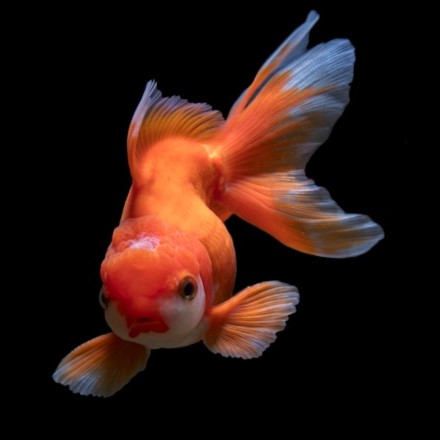

In [4]:
#Имя входного файла
input_file_name = 'images/fish.jpg'

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

#Импорты необходимых модулей
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
from pathlib import Path

# Загружаем изображение
img_path = Path(input_file_name).resolve()
print("Исходное изображение - фото золотой рыбки")
display(Image(filename = img_path))

### Получение предсказаний при помощи модели VGG16

Выполняем препроцессинг изображения, загружаем модель VGG16. Выводим структуру модели и первые 5 предсказаний. Находим класс предсказанного изображения.

In [ ]:
#Загружаем изображение и производим препроцессинг
img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img = keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = keras.applications.vgg16.preprocess_input(img)

# Загружаем модель VGG16
model = keras.applications.VGG16(weights='imagenet', include_top=True)

#Получаем предсказания
preds = model.predict(img)
decoded_preds = keras.applications.vgg16.decode_predictions(preds, top=5)[0];

# Вывод структуры модели
model.summary()  

print('Топ 5 предсказаний:')
for pred in decoded_preds:
    print('%s - %.4f%%' % (pred[1], pred[2]*100))
    
#Предсказанный класс изображения
predicted_class = np.argmax(preds[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Топ 5 предсказаний:
mosquito_net - 4.8541%
toilet_tissue - 3.3198%
axolotl - 2.1140%
envelope - 1.7143%
Band_Aid - 1.6146%


### Grad CAM

Выполняем визуализацию карты активации слоя при помощи процедуры Grad CAM. Вычисляем градиенты, создаем карту активации и накладываем ее на исходное изображение

Карта активации


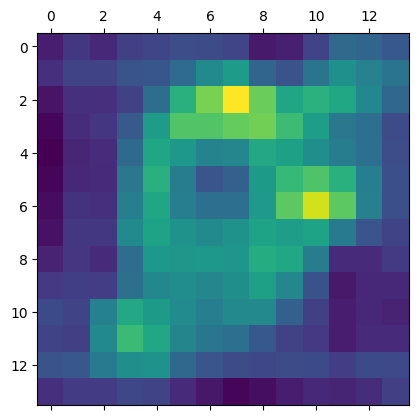

Тепловая карта, наложенная на изображение


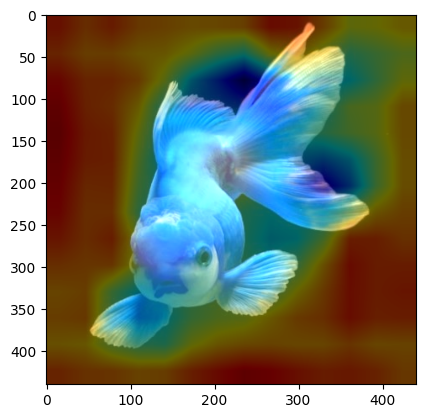

Изображения успешно сохранены


In [6]:
target_layer_name = "block5_conv3" # Название слоя, для которого выводим карту активации
target_layer_filters = 512 # Количество фильтров в слое

# Вычисляем градиенты с помощью GradientTape
with tf.GradientTape() as tape:
    target_layer = model.get_layer(target_layer_name)
    iterate = tf.keras.Model([model.input], [target_layer.output, model.output])
    conv_output, predictions = iterate([img])
    loss = predictions[:, predicted_class]  # Выбираем значение предсказанного класса
    grads = tape.gradient(loss, conv_output)  # Вычисляем градиенты
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Среднее значение градиентов

# Корректируем выход свёрточного слоя
conv_output = conv_output.numpy()[0]
pooled_grads = pooled_grads.numpy()

for i in range(target_layer_filters):  
    conv_output[:, :, i] *= pooled_grads[i]

# Создаём карту активации
heatmap = np.mean(conv_output, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Отображаем карту активации
print('Карта активации')
plt.matshow(heatmap)
plt.show()

# Наложение карты на изображение
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img
superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

# Сохраняем изображение с наложенной тепловой картой
print('Тепловая карта, наложенная на изображение')
plt.imshow(superimposed_img)
plt.show()

#Сохранение тепловой карты и изображения с наложенной тепловой картой в файлы
write_success = cv2.imwrite('images/superimposed_image.jpg', superimposed_img)
write_success = write_success and cv2.imwrite('images/heat_map.jpg', heatmap)

print("Изображения успешно сохранены" if write_success else "Ошибка сохранения изображений")